In [1]:
import cv2, numpy as np

def preflow_mask(img_bgr, k=7):
    # 1) intensity (dim)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    Y = gray / 255.0
    dim = (Y < 0.15)  # too dark

    # 2) local contrast (variance)
    m  = cv2.blur(Y, (k,k))
    m2 = cv2.blur(Y*Y, (k,k))
    var = np.clip(m2 - m*m, 0, 1)
    low_var = (var < 0.002)

    # 3) gradient magnitude (no edges ⇒ no features)
    gx = cv2.Sobel(gray, cv2.CV_32F, 1, 0, ksize=3)
    gy = cv2.Sobel(gray, cv2.CV_32F, 0, 1, ksize=3)
    grad = np.sqrt(gx*gx + gy*gy) / 255.0
    low_grad = (grad < 0.02)

    # 4) structure tensor min-eigenvalue (Shi–Tomasi cornerness)
    # low eigenvalue ⇒ aperture problem
    min_eig = cv2.cornerMinEigenVal(gray, blockSize=k, ksize=3)
    flat = (min_eig < 1e-6)

    # Combine: mark as BAD if ANY of these are true
    bad = dim | low_var | low_grad | flat
    # Keep = ~bad
    keep = (~bad).astype(np.uint8)*255
    return keep, {"dim":dim, "low_var":low_var, "low_grad":low_grad, "flat":flat}

# Optional: improve lighting before flow
def preprocess_for_flow(img_bgr):
    ycrcb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2YCrCb)
    y,cr,cb = cv2.split(ycrcb)
    y = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8)).apply(y)   # local contrast
    ycrcb = cv2.merge([y,cr,cb])
    out = cv2.cvtColor(ycrcb, cv2.COLOR_YCrCb2BGR)
    out = cv2.bilateralFilter(out, d=5, sigmaColor=25, sigmaSpace=7)  # denoise w/ edge keep
    return out


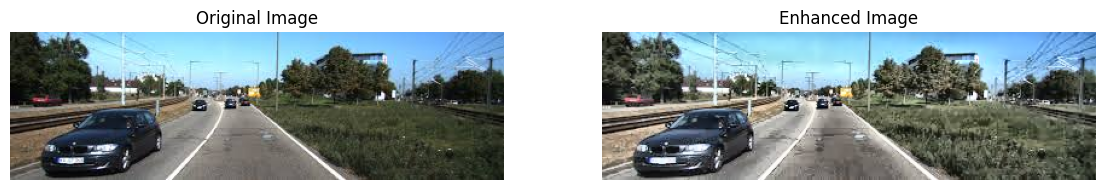

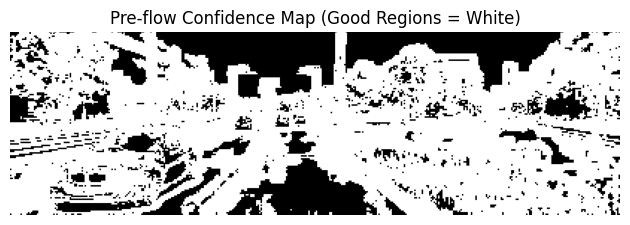

In [3]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# --- Load image ---
img = cv2.imread("/home/user/Desktop/DPVO/conf_map_demo/KITTI_sample.png")

if img is None:
    raise FileNotFoundError("Image not found!")

# --- Optional: improve contrast before mask ---
img_pre = preprocess_for_flow(img)

# --- Compute preflow mask ---
keep, masks = preflow_mask(img_pre)

# --- Visualize ---
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")

plt.subplot(1, 2, 2)
plt.title("Enhanced Image")
plt.imshow(cv2.cvtColor(img_pre, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()

plt.title("Pre-flow Confidence Map (Good Regions = White)")
plt.imshow(keep, cmap="gray")
plt.axis("off")

plt.tight_layout()
plt.show()

# for key, mask in masks.items():
#     plt.figure()
#     plt.title(key)
#     plt.imshow(mask, cmap='gray')
#     plt.axis('off')
#     plt.show()